# PRMT-2944 Graph of technical failures

In [84]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.lines as mlines

def add_leading_zero(num: int) -> str:
    return str(num).zfill(2)

In [3]:
data_folder_2_day_cutoff="s3://prm-gp2gp-transfer-data-preprod/v11/cutoff-2"
transfer_parquet_files_2_day_cutoff_10 = [f"{data_folder_2_day_cutoff}/2022/10/{add_leading_zero(day)}/2022-10-{add_leading_zero(day)}-transfers.parquet" for day in range(1, 32)]
transfer_parquet_files_2_day_cutoff_11 = [f"{data_folder_2_day_cutoff}/2022/11/{add_leading_zero(day)}/2022-11-{add_leading_zero(day)}-transfers.parquet" for day in range(1, 8)]
transfers_raw_2_day_cutoff_10 = pd.concat([pd.read_parquet(file) for file in transfer_parquet_files_2_day_cutoff_10])
transfers_raw_2_day_cutoff_11 = pd.concat([pd.read_parquet(file) for file in transfer_parquet_files_2_day_cutoff_11])

In [4]:
transfers_raw_2_day_cutoff = pd.concat(
    [
        transfers_raw_2_day_cutoff_10,
        transfers_raw_2_day_cutoff_11
    ])

In [5]:
total_transfers = transfers_raw_2_day_cutoff.shape[0]
total_transfers

317553

# Summary
## 2 day cutoff

In [6]:
two_day = transfers_raw_2_day_cutoff.value_counts("status")
two_day

status
Integrated on time      217520
Process failure          91414
Technical failure         7384
Unclassified failure      1235
dtype: int64

In [7]:
two_day_percentage = transfers_raw_2_day_cutoff.value_counts("status").apply(lambda x: (x / total_transfers)) * 100
two_day_percentage

status
Integrated on time      68.498802
Process failure         28.787006
Technical failure        2.325281
Unclassified failure     0.388911
dtype: float64

In [8]:
transfers_raw_2_day_cutoff['day'] = transfers_raw_2_day_cutoff['date_requested'].dt.to_period('D')
transfers_raw_2_day_cutoff['week'] = transfers_raw_2_day_cutoff['date_requested'].dt.to_period('W')
grouped_2_day_transfers = transfers_raw_2_day_cutoff.groupby("day").agg({'conversation_id':'count'}).reset_index()
# grouped_2_day_transfers

In [9]:
technical_failure_2_day_cutoff_bool = transfers_raw_2_day_cutoff["status"] == "Technical failure"
technical_failure_2_day_cutoff_bool = transfers_raw_2_day_cutoff[technical_failure_2_day_cutoff_bool]
grouped_technical_failure_2_day_cutoff = technical_failure_2_day_cutoff_bool.groupby("day").agg({'conversation_id':'count'}).reset_index()

# grouped_technical_failure_2_day_cutoff

In [10]:
merged_grouped_2_day_transfers = grouped_2_day_transfers.merge(grouped_technical_failure_2_day_cutoff, left_on="day", right_on="day", how="outer")
merged_grouped_2_day_transfers['percentage'] = (merged_grouped_2_day_transfers['conversation_id_y'] / merged_grouped_2_day_transfers['conversation_id_x']) * 100

<AxesSubplot:xlabel='day'>

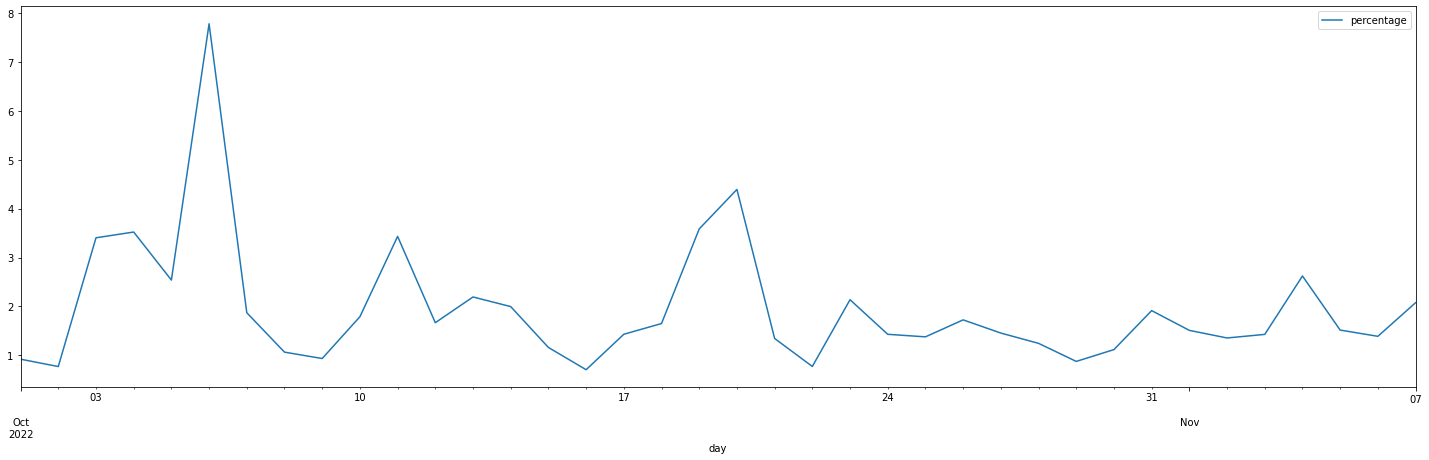

In [11]:
merged_grouped_2_day_transfers.plot(x="day", y="percentage", figsize=(25,7))

In [12]:
merged_grouped_2_day_transfers["percentage"].describe()

count    38.000000
mean      1.950552
std       1.311085
min       0.705882
25%       1.270130
50%       1.513569
75%       2.122525
max       7.783459
Name: percentage, dtype: float64

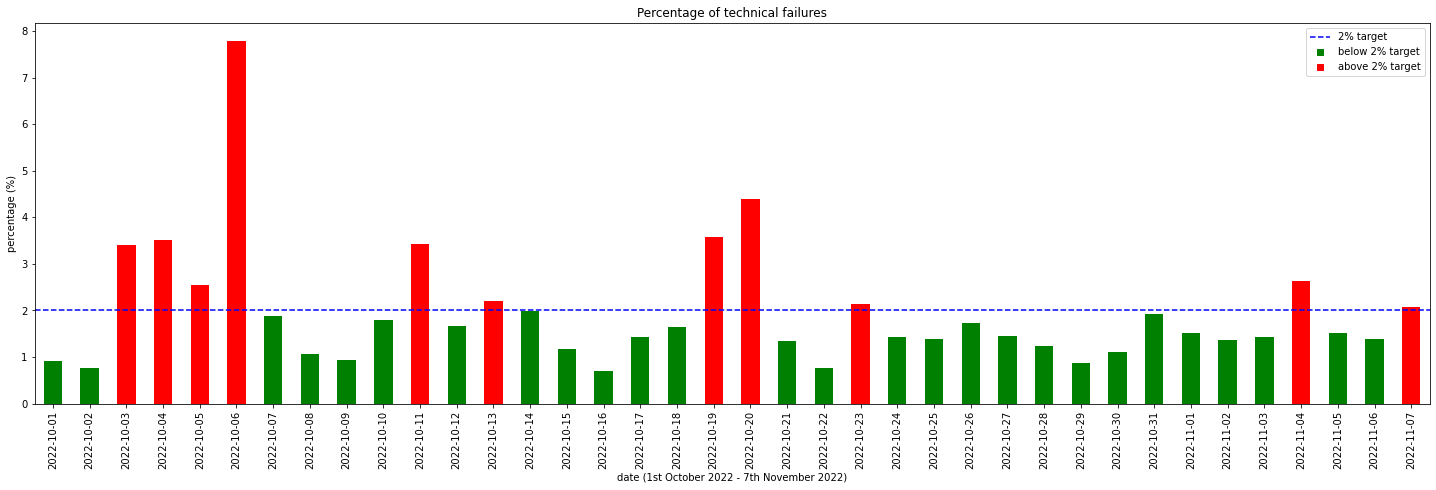

In [110]:
colors = ["red" if i > 2.0 else "green" for i in merged_grouped_2_day_transfers["percentage"]]

bar_chart = merged_grouped_2_day_transfers \
    .plot(kind="bar", x="day", y="percentage", figsize=(25,7), color=colors, legend=colors) \
    .axhline(y=2, color='b', linestyle='--')

plt.title("Percentage of technical failures")
plt.xlabel("date (1st October 2022 - 7th November 2022)")
plt.ylabel("percentage (%)")
plt.legend().remove()


target = mlines.Line2D([], [], color='blue', ls='--', label='2% target')
below_target = mlines.Line2D([], [], color='green', marker="s", ls="", label='below 2% target')
above_target = mlines.Line2D([], [], color='red', marker="s", ls="", label='above 2% target')
plt.legend(handles=[target, below_target, above_target,])
